# Predict next time series value with LSTM + Lineal

* https://www.crosstab.io/articles/time-series-pytorch-lstm
* https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset
* https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random

import torch
from torch.nn import MSELoss
from torch.utils.data import DataLoader

import pytorch_common.util    as pu
from   pytorch_common.util import set_device_name, \
                                  get_device, \
                                  LoggerBuilder

from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel

from pytorch_common.callbacks.output import OutputHook


from data   import SequenceDataset, \
                   standarizer, \
                   variable_to_sequences, \
                   features_target_split, \
                   train_test_split
from util   import set_seed, \
                   loss_wrapper

from module import TimeSeriesPredictor

from scipy import stats
from scipy.signal import savgol_filter

## Functions

In [4]:
def interpolation_plot(test_dataset, sequence_size, times=500):
    feature, _  = test_dataset[0]
    complete_pred_values = feature.squeeze(1).tolist()

    pred_values, true_values = [], []

    for time in  range(1, times+1):
        features = complete_pred_values[-sequence_size:]
        input = torch.tensor(features).unsqueeze(1).unsqueeze(0)

        next_value  = model.predict(input)

        complete_pred_values.append(next_value.item())
        pred_values.append(next_value.item())

        _, y_true = test_dataset[time]
        true_values.append(y_true.item())

    plot_pred_true(pred_values, true_values, times)

def plot_pred_true(y_pred, y_true, times):
    sns.set_style("darkgrid")
    plt.plot(y_true[:times], color='green',label="True")        
    plt.plot(y_pred[:times], color='blue', label="Prediction")
    plt.legend()
    plt.show()

def plot_eval(times):
    y_pred, y_true = model.validation(test_loader)
    plot_pred_true(y_pred, y_true, times)

def plot(y, times=100):
    sns.set_style("darkgrid")
    plt.plot(y[:times], color='green')
    plt.legend()
    plt.show()

## Setup

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')

In [7]:
pu.get_device()

device(type='cuda', index=0)

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.__version__

'1.11.0'

In [10]:
set_seed(42)

In [11]:
WEIGHTS_PATH   = '../weights'
WINDOW_SIZE    = 200
N_WORKERS      = 24
BATCH_SIZE     = 200
TRAIN          = True
n_hidden_units = 5
sequence_size  = WINDOW_SIZE -1
n_epochs       = 30
n_layers       = 5
dropout        = 0
test_percent   = 0.2

CFG = {
    'etherium': { 'path': '../datasets/ETH_1H.csv',                 'variable': 'close' },
    'min-temp': { 'path': '../datasets/daily-min-temperatures.csv', 'variable': 'temp'  },
    'dataset' : 'min-temp'
}

DATASET_PATH = CFG[CFG['dataset']]['path']
VARIABLE     = CFG[CFG["dataset"]]["variable"]

## Preprocessing

#### 1. Load dataset.

In [12]:
df = pd.read_csv(DATASET_PATH)
df.columns = df.columns.str.lower()
df = df[['date', VARIABLE]]

dataset = df.sort_values(by='date',ascending=True)
dataset.head()

,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [13]:
dataset.shape

(3650, 2)

/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temp'>

<Figure size 432x288 with 1 Axes>

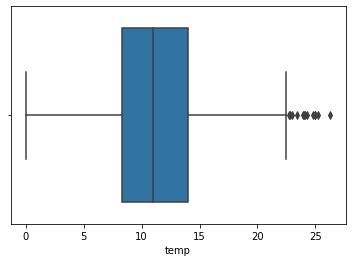

In [14]:
sns.boxplot(dataset[VARIABLE])

In [15]:
dataset['zscore'] = stats.zscore(dataset[VARIABLE].values)
dataset = dataset[dataset['zscore'] < 2.5]
dataset = dataset.sort_values(by='date',ascending=True)
dataset.shape

(3612, 3)

/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temp'>

<Figure size 432x288 with 1 Axes>

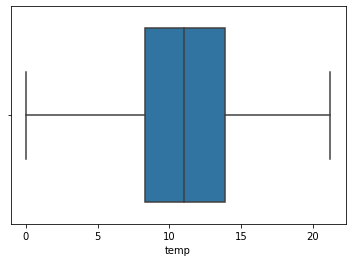

In [16]:
sns.boxplot(dataset[VARIABLE])

#### 2. Train-test splot and normalize data:

In [17]:
train_set,      test_set      = train_test_split(dataset, test_percent)
norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=[VARIABLE])

norm_train_set.shape, norm_test_set.shape

((2890, 4), (722, 4))

In [18]:
norm_train_set.tail()

,date,temp,zscore,norm_temp
2919,1988-12-30,14.1,0.717771,0.804396
2920,1989-01-01,14.3,0.766896,0.855905
2921,1989-01-02,17.4,1.528327,1.654294
2922,1989-01-03,18.5,1.798513,1.937594
2923,1989-01-04,16.8,1.380953,1.499767


In [19]:
norm_test_set.head()

,date,temp,zscore,norm_temp
2924,1989-01-05,11.5,0.079151,0.134779
2925,1989-01-06,9.5,-0.412095,-0.380311
2926,1989-01-07,12.2,0.251087,0.315060
2927,1989-01-08,15.7,1.110768,1.216468
2928,1989-01-09,16.3,1.258142,1.370995


2022-08-15 14:54:53,995 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 1 Axes>

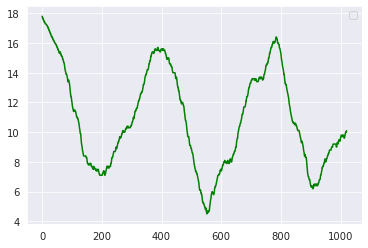

,date,temp,zscore,norm_temp
0,1981-01-01,17.8,2.338883,2.504193
1,1981-01-02,17.7,1.651139,1.783067
2,1981-01-03,17.7,1.872199,2.014857
3,1981-01-04,17.6,0.840583,0.933168
4,1981-01-05,17.6,1.135330,1.242222


In [20]:
norm_train_set[VARIABLE] = savgol_filter(norm_train_set[VARIABLE].values, 101, 2) # window size 51, polynomial order 3

norm_train_set = norm_train_set.sort_values(by='date',ascending=True)
norm_train_set[VARIABLE] = norm_train_set[VARIABLE].apply(lambda x: round(x, 1))

plot(norm_train_set[VARIABLE], 1000)

norm_train_set.head()

#### 3. Separare into sequences using a sliding window.

In [21]:
variable_norm_values = norm_train_set[f'norm_{VARIABLE}']

train_set_sequences = variable_to_sequences(variable_norm_values, WINDOW_SIZE)
test_set_sequences  = variable_to_sequences(variable_norm_values,  WINDOW_SIZE)

train_set_sequences.shape, test_set_sequences.shape

((2691, 200), (2691, 200))

#### 4. Separate sequences into (features=sequence-1, target=last):

In [22]:
train_features, train_targets = features_target_split(train_set_sequences)
test_features,  test_targets  = features_target_split(test_set_sequences)

train_features.shape, train_targets.shape, test_features.shape, test_targets.shape

((2691, 199), (2691,), (2691, 199), (2691,))

In [23]:
torch.tensor(train_features).unsqueeze(2).float().shape

torch.Size([2691, 199, 1])

#### 5. Create a dataset for both train an test sets:

In [24]:
train_dataset = SequenceDataset(train_features, train_targets)
test_dataset  = SequenceDataset(test_features, test_targets)

len(train_dataset), len(test_dataset)

(2691, 2691)

In [25]:
f, t = train_dataset[0]
f.shape, t.shape

(torch.Size([199, 1]), torch.Size([]))

In [26]:
f, t = test_dataset[0]
f.shape, t.shape

(torch.Size([199, 1]), torch.Size([]))

#### 6. Create dataloader for both tra and test datasets:

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

# f, t = next(iter(train_loader))
# f.shape, t.shape

In [28]:
# f, t = next(iter(test_loader))
# f.shape, t.shape

# Model Definition

In [29]:
model = TimeSeriesPredictor(
    n_hidden_units = n_hidden_units, 
    n_layers       = n_layers,
    dropout        = dropout
).to(pu.get_device())

model

TimeSeriesPredictor(
  (rnn): LSTM(1, 5, num_layers=5, batch_first=True)
  (linear): Linear(in_features=5, out_features=1, bias=True)
)

In [30]:
# f, t = next(iter(test_loader))
# f.shape, model(f).shape

# Train

<Figure size 576x288 with 1 Axes>

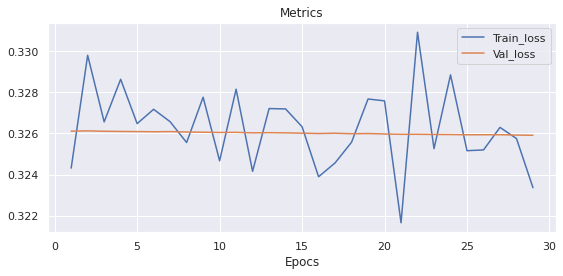

<Figure size 576x288 with 1 Axes>

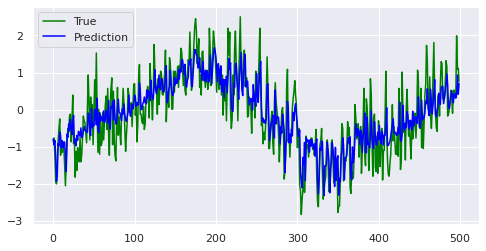

<Figure size 576x288 with 1 Axes>

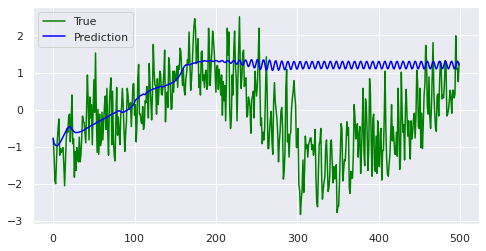

In [40]:
if TRAIN:
    sns.set(rc = {'figure.figsize':(8,4)})

    learning_rate  = 0.0001

    loss_fn = MSELoss()

    model.fit(
        train_loader,
        loss_fn   = loss_fn,
        epochs    = n_epochs,
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr = learning_rate
        ),
        callbacks   = [
            Validation(
                test_loader,
                metrics       = { 'val_loss': loss_wrapper(loss_fn) },
                each_n_epochs = 1
            ),
            Logger(['time', 'epoch', 'train_loss', 'val_loss']),
            MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=5),
            OutputHook(lambda ctx: plot_eval(times=500), plot_each_n_epochs=5),
            OutputHook(lambda ctx: interpolation_plot(test_dataset, sequence_size, times=500), plot_each_n_epochs=5), 
            #, SaveBestModel(metric='val_loss', path=WEIGHTS_PATH, experiment_name='lstm-time-series')
        ]
    )